In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import pandas as pd
from scipy.stats import chi2,norm
from scipy import optimize

In [ ]:
#Import S&P data
import pandas_datareader.data as web
import datetime

In [ ]:
tickers = {'Ford':'F','Caterpillar':'CAT','Disney':'DIS','McDonald\'s':'MCD', \
         'Coca-Cola':'KO','Pepsi':'PEP','Walmart':'WMT','Citigroup':'C', \
         'Wells Fargo':'WFC','JPMorgan':'JPM','Apple':'AAPL','IBM':'IBM', \
         'Pfizer':'PFE','Johnson & Johnson':'JNJ','Exxon':'XOM', \
         'Marathon Oil':'MRO','Edison':'ED','AT&T':'T','Verizon':'VZ','Newmont':'NEM'}
start = datetime.datetime(2004,11,30)
end = datetime.datetime(2008,9,30)

In [ ]:
#Manually specify mean historical market cap data
#Could not get api to work
#Pulled from Wolfram Alpha
market_cap = {'Ford':15.99,'Caterpillar':42.75,'Disney':59.79,'McDonald\'s':52.31, \
         'Coca-Cola':114.2,'Pepsi':103.2,'Walmart':201.21,'Citigroup':215.9, \
         'Wells Fargo':108.2,'JPMorgan':146.3,'Apple':83.87,'IBM':142.7, \
         'Pfizer':174.7,'Johnson & Johnson':186.8,'Exxon':416, \
         'Marathon Oil':18.04,'Edison':11.62,'AT&T':157.5,'Verizon':95.78,'Newmont':20.1}

In [ ]:
#load stock data
monthly_raw = pd.DataFrame()
monthly_per = pd.DataFrame()
means = pd.DataFrame(index=tickers.values())
TOTAL_mkt = sum(market_cap.values())
for key in tickers.keys():
  series = web.get_data_yahoo(tickers[key],start,end,interval='m')['Adj Close']
  monthly_raw[tickers[key]] = series
  monthly_per[tickers[key]] = (np.divide(series.values[1:],series.values[:-1])) - 1
  means.loc[tickers[key],'return'] = monthly_per[tickers[key]].mean(axis=0)
  means.loc[tickers[key],'mkt weight'] = market_cap[key]/TOTAL_mkt
monthly_per.index = monthly_raw.index[1:]

In [ ]:
#Calculate the covariance matrix
zeroed = monthly_per.values.T - means['return'].values.reshape(20,1)
Sigma = 12*(1/(zeroed.shape[1]-1))*zeroed@zeroed.T

In [ ]:
#Load data to calculate the risk-free rate
CPI = web.get_data_fred('MEDCPIM158SFRBCLE',start,end)
bond1M = web.get_data_fred('GS1M',start,end)
rf = 12*((bond1M.iloc[:,0] - CPI.iloc[:,0]).mean())/100

In [ ]:
#Calculate lambda
Exmkt = 12*np.dot(means['return'],means['mkt weight'])
sig_mkt = means['mkt weight'].values.reshape(1,20)@Sigma@means['mkt weight'].values.reshape(20,1)
sig_mkt = sig_mkt[0][0]
lamb = (Exmkt - rf)/sig_mkt

mu_yr = 12*means['return'].values.reshape(20,1)

In [ ]:
print(lamb)
print(rf)

0.9602993410123203
0.06611697253189557


In [ ]:
def MVO(mu,Q,lamb,R,short=True,Version=1):
  """Performs standard MVO. mu being the expected return,
  Q the covariance matrix, lambda the risk aversion coefficient,
  R the desired returns (for Version 2)."""
  
  N = len(mu)
  x = cp.Variable(shape=(N,1))

  #Version1
  if Version == 1:
    constraints = [np.ones((1,N))@x == 1]
    obj = cp.Minimize(lamb*cp.quad_form(x,Q) - mu.T@x)

  #Version2
  elif Version == 2:
    obj = cp.Minimize(lamb*cp.quad_form(x,Q))
    constraints = [mu.T@x >= R, np.ones((1,N))@x == 1]

  if not short:
    constraints += [x >= 0]

  prob = cp.Problem(obj,constraints)
  prob.solve(max_iter=100000)

  return x.value

In [ ]:
def PrintResults(x,mu,Q,rf,name):
  """Prints Results in an easy to read format."""
  try:
    print(f'{name} returns: {(mu.T@x)[0][0]*100:7.2f}%')
    print(f'{name} variance: {(x.T@Q@x)[0][0]*100:6.2f}%')
    print(f'{name} SD: {np.sqrt((x.T@Q@x)[0][0])*100:12.2f}%')
    print(f'{name} Sharpe: {((mu.T@x)[0][0] - rf)/np.sqrt((x.T@Q@x)[0][0]):8.2f}')
  except:
    print(f'{name} returns: {(mu.T@x)*100:7.2f}%')
    print(f'{name} variance: {(x.T@Q@x)*100:6.2f}%')
    print(f'{name} SD: {np.sqrt((x.T@Q@x))*100:12.2f}%')
    print(f'{name} Sharpe: {((mu.T@x) - rf)/np.sqrt((x.T@Q@x)):8.2f}')

In [ ]:
#Try MVO on our estimated data
rets = 0.2
x_MVO = MVO(mu_yr,Sigma,lamb,rets,short=True)
PrintResults(x_MVO,mu_yr,Sigma,rf,'MVO')

MVO returns:  484.33%
MVO variance: 248.93%
MVO SD:       157.78%
MVO Sharpe:     3.03


In [ ]:
def BoxRMVO(mu,Q,lamb,R,CI,num_obs,short=True,Version=1):
  """Box Robust MVO.  Similar to the above MVO function, but
  with the added confidence interval (CI), and num of observations
  (num_obs) for calculating epsilon."""
  
  N = len(mu)
  x = cp.Variable(shape=(N,1))
  y = cp.Variable(shape=(N,1))

  eps = norm.ppf(CI)

  Theta = np.diag(np.diag(Q))/num_obs
  deltas = np.sqrt(np.diag(Theta).reshape(1,N))
  deltas = eps*deltas

  #Version 1
  if Version == 1:
    obj = cp.Minimize(lamb*cp.quad_form(x,Q) - mu.T@x + deltas@y)
    constraints = [np.ones((1,N))@x == 1, \
                 y >= x, y >= -x]
  #Version 2
  elif Version == 2:
    obj = cp.Minimize(cp.quad_form(x,Q))
    constraints = [mu.T@x - deltas@y >= R, np.ones((1,N))@x == 1, \
                 y >= x, y >= -x]
  
  else:
    print('Please choose a valid version.')
    return

  if not short:
    constraints += [x >= 0]
  
  prob = cp.Problem(obj,constraints)
  prob.solve(solver=cp.SCS,max_iters=100000)

  return x.value

In [ ]:
#Test out box RMVO
x_bRMVO90 = BoxRMVO(mu_yr,Sigma,lamb,rets,0.9,monthly_per.values.shape[0],short=True)
PrintResults(x_bRMVO90,mu_yr,Sigma,rf,'Box MVO - 90%')

Box MVO - 90% returns:  279.84%
Box MVO - 90% variance:  94.26%
Box MVO - 90% SD:        97.09%
Box MVO - 90% Sharpe:     2.81


In [ ]:
#Test at 95 CI
x_bRMVO95 = BoxRMVO(mu_yr,Sigma,lamb,rets,0.95,monthly_per.values.shape[0],short=True)
PrintResults(x_bRMVO95,mu_yr,Sigma,rf,'Box MVO - 95%')

Box MVO - 95% returns:  232.84%
Box MVO - 95% variance:  69.77%
Box MVO - 95% SD:        83.53%
Box MVO - 95% Sharpe:     2.71


In [ ]:
def EllipseRMVO(mu,Q,lamb,R,CI,num_obs,short=True,Version=1):
  """Similar to above, but an implementation of the Ellipse RMVO."""
  
  N = len(mu)
  x = cp.Variable(shape=(N,1))
  eps = chi2.ppf(CI,N)
  eps = np.sqrt(eps)

  Theta = np.diag(np.diag(Q))/num_obs


  #Version 1
  if Version == 1:

    obj = cp.Minimize(lamb*cp.quad_form(x,Q) - mu.T@x + eps*cp.norm2(np.sqrt(Theta)@x))
    constraints = [np.ones((1,N))@x == 1]
    
  #Version 2
  elif Version == 2:

    obj = cp.Minimize(cp.quad_form(x,Q))
    constraints = [mu.T@x - eps*cp.norm2(np.sqrt(Theta)@x) >= R, \
                   np.ones((1,N))@x == 1]
  
  else:
    print('Mispecified version number.')
    return
  
  if not short:
    constraints += [x >= 0]

  prob = cp.Problem(obj,constraints)
  prob.solve(solver=cp.SCS,max_iters=100000)

  return x.value


In [ ]:
#Test out ellipse RMVO
x_eRMVO90 = EllipseRMVO(mu_yr,Sigma,lamb,rets,0.90,monthly_per.values.shape[0],short=True)
PrintResults(x_eRMVO90,mu_yr,Sigma,rf,'Ellipse MVO - 90%')

Ellipse MVO - 90% returns:  223.99%
Ellipse MVO - 90% variance:  62.53%
Ellipse MVO - 90% SD:        79.08%
Ellipse MVO - 90% Sharpe:     2.75


In [ ]:
x_eRMVO95 = EllipseRMVO(mu_yr,Sigma,lamb,rets,0.95,monthly_per.values.shape[0],short=True)
PrintResults(x_eRMVO95,mu_yr,Sigma,rf,'Ellipse MVO - 95%')

Ellipse MVO - 95% returns:  213.12%
Ellipse MVO - 95% variance:  57.42%
Ellipse MVO - 95% SD:        75.78%
Ellipse MVO - 95% Sharpe:     2.73


In [ ]:
lamb

0.9602993410123203

In [ ]:
def RiskContr(mu,Q):
  """Intermediate function to calculate the risk contribution
  for each asset.  Usefull for Risk Parity function."""
  
  N = len(mu)
  mu.shape = (N,)
  return mu.dot(Q)*mu

In [ ]:
def RiskParity(Q):
  """Risk Parity optimization.  ONly takes the covariance
  matrix Q. Could be modified for specific weight vectors.
  Unlike the other optimizations, must be done in scipy (and
  not CVX) as the DCP rules are violated by the formulation.
  NOTE: returns an additional parameter, theta, as the first
  value of x, the remained values being the weights."""

  options = {'ftol': 1e-20, 'maxiter': 1000000}
  N = Q.shape[0]

  def objective(x):
    weights = x[1:]
    theta = x[0]
    risks = RiskContr(weights,Q)

    return np.sum(np.square(risks - theta))

  x0 = np.ones((N+1,))*(1/N)
  x0 = x0.tolist()
  #bounds = [None]
  bounds  = [(0, 1) for i in range(N)]
  bounds.append((None,None))
  bounds.reverse()
  constraints = {'type': 'eq', 'fun': lambda x: np.sum(x[1:]) - 1}
  res = optimize.minimize(objective, x0, method='SLSQP', bounds=bounds,\
                                constraints=constraints,options=options)
  
  return res.x



In [ ]:
#Test out rsik
RP = RiskParity(Sigma)

In [ ]:
#Drop theta and evaluate performance
x_RP = RP[1:]
PrintResults(x_RP.reshape(20,1),mu_yr,Sigma,rf,'Risk Parity')

Risk Parity returns:    7.78%
Risk Parity variance:   0.56%
Risk Parity SD:         7.50%
Risk Parity Sharpe:     0.16


In [ ]:
#Finally, test on the market portfolio.
PrintResults(means['mkt weight'].values.reshape(20,1),mu_yr,Sigma,rf,'Market')

Market returns:    7.63%
Market variance:   1.06%
Market SD:        10.30%
Market Sharpe:     0.10


In [ ]:
def GenRiskBar(mu,Q,labels,title):
  """Function that generates a bar graph of risk
  distribution across assets."""
  
  plt.bar(labels,RiskContr(mu,Q)/np.sum(RiskContr(mu,Q)),color='black')
  plt.ylabel('Relative Risk')
  plt.xticks(rotation=45)
  plt.grid()
  plt.title(title)
  plt.show()
  #plt.savefig(title + '_hist.png')

In [ ]:
graphs = {'MVO':x_MVO,'Box - 90%':x_bRMVO90, 'Box - 95%':x_bRMVO95,\
          'Ellipse - 90%':x_eRMVO90, 'Ellipse - 95%':x_eRMVO95, \
          'Risk Parity':x_RP, 'Market':means['mkt weight'].values}

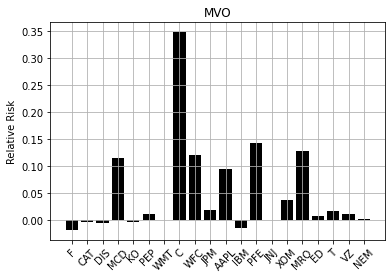

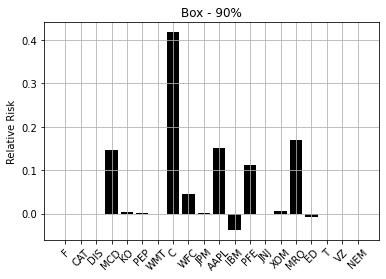

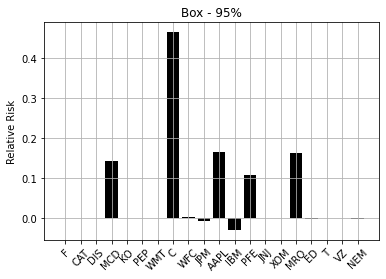

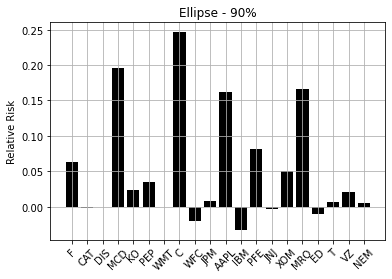

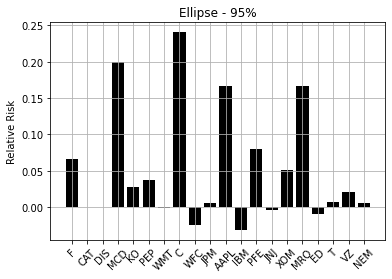

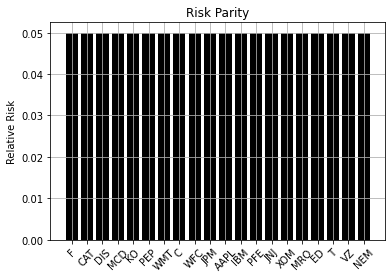

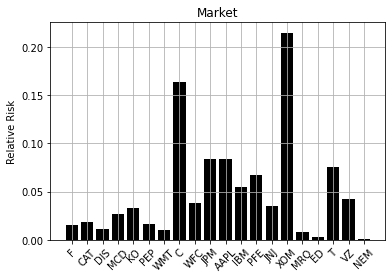

In [ ]:
#Plot the relative risk held in each asset 
#for each model; only for illustrative purpose
#i.e. making sure RP works
for key in graphs.keys():
  GenRiskBar(graphs[key],Sigma,tickers.values(),key)

In [ ]:
#Adding the october and november data to the dataset
#similar to what was done in the first part
start_add = datetime.datetime(2008,9,30)
end_add = datetime.datetime(2008,11,30)
add_raw = pd.DataFrame()
day_raw = pd.DataFrame()
day_per = pd.DataFrame()
for key in tickers.keys():
  series = web.get_data_yahoo(tickers[key],start_add,end_add,interval='m')['Adj Close']
  series_day = web.get_data_yahoo(tickers[key],start_add,end_add,interval='d')['Adj Close']
  add_raw[tickers[key]] = series
  day_raw[tickers[key]] = series_day
  day_per[tickers[key]] = (np.divide(series_day.values[1:],series_day.values[:-1])) - 1
monthly_raw = monthly_raw.append(add_raw)

day_per.index = day_raw.iloc[1:].index

for key in tickers.keys():
  means.loc[tickers[key],'Oct'] = day_per.loc['2008-10-1':'2008-11-1',tickers[key]].mean(axis=0)
  means.loc[tickers[key],'Nov'] = day_per.loc['2008-11-1':,tickers[key]].mean(axis=0)

In [ ]:
zeroed = day_per.values.T - means['Oct'].values.reshape(20,1)
cov_oct = (1/(zeroed.shape[1]-1))*zeroed@zeroed.T
zeroed = day_per.values.T - means['Nov'].values.reshape(20,1)
cov_nov = (1/(zeroed.shape[1]-1))*zeroed@zeroed.T

In [ ]:
monthly_per.loc['2008-10-1'] = (np.divide(monthly_raw.loc['2008-10-1'].values,monthly_raw.loc['2008-9-1'].values)) - 1
monthly_per.loc['2008-11-1'] = (np.divide(monthly_raw.loc['2008-11-1'].values,monthly_raw.loc['2008-10-1'].values)) - 1
monthly_raw.index = monthly_raw.index.normalize()
monthly_per.index = pd.to_datetime(monthly_per.index)

In [ ]:
#Derive new risk free rate for the actual data
CPI_add = web.get_data_fred('MEDCPIM158SFRBCLE',start_add,end_add)
bond1M_add = web.get_data_fred('GS1M',start_add,end_add)

In [ ]:
#Calculate risk free rates and covariance matrices
#for Oct and Nov returns
rf_oct = ((bond1M_add.iloc[:,0] - CPI_add.iloc[:,0])/100)[0]
rf_nov = ((bond1M_add.iloc[:,0] - CPI_add.iloc[:,0])/100)[1]

##Part A

In [ ]:
#Print Results for PART A
for name in graphs.keys():
  PrintResults(graphs[name].reshape(20,1),monthly_per.loc['2008-10-1'].values.reshape(20,1),\
               cov_oct,rf_oct,name)

MVO returns:   89.25%
MVO variance:  32.23%
MVO SD:        56.77%
MVO Sharpe:     1.61
Box - 90% returns:   63.61%
Box - 90% variance:  11.30%
Box - 90% SD:        33.62%
Box - 90% Sharpe:     1.95
Box - 95% returns:   55.74%
Box - 95% variance:   8.87%
Box - 95% SD:        29.79%
Box - 95% Sharpe:     1.94
Ellipse - 90% returns:   49.33%
Ellipse - 90% variance:   5.31%
Ellipse - 90% SD:        23.05%
Ellipse - 90% Sharpe:     2.22
Ellipse - 95% returns:   46.34%
Ellipse - 95% variance:   4.78%
Ellipse - 95% SD:        21.87%
Ellipse - 95% Sharpe:     2.21
Risk Parity returns:  -14.57%
Risk Parity variance:   0.19%
Risk Parity SD:         4.40%
Risk Parity Sharpe:    -2.87
Market returns:  -12.45%
Market variance:   0.23%
Market SD:         4.84%
Market Sharpe:    -2.18


##PART B

In [ ]:
#Print results for part B
for name in graphs.keys():
  PrintResults(graphs[name].reshape(20,1),monthly_per.loc['2008-11-1'].values.reshape(20,1),\
               cov_nov,rf_nov,name)

MVO returns:  189.91%
MVO variance:  32.23%
MVO SD:        56.77%
MVO Sharpe:     3.38
Box - 90% returns:   87.53%
Box - 90% variance:  11.30%
Box - 90% SD:        33.62%
Box - 90% Sharpe:     2.66
Box - 95% returns:   68.16%
Box - 95% variance:   8.88%
Box - 95% SD:        29.79%
Box - 95% Sharpe:     2.35
Ellipse - 90% returns:   32.61%
Ellipse - 90% variance:   5.32%
Ellipse - 90% SD:        23.06%
Ellipse - 90% Sharpe:     1.49
Ellipse - 95% returns:   29.71%
Ellipse - 95% variance:   4.79%
Ellipse - 95% SD:        21.88%
Ellipse - 95% Sharpe:     1.44
Risk Parity returns:   -1.24%
Risk Parity variance:   0.19%
Risk Parity SD:         4.41%
Risk Parity Sharpe:     0.14
Market returns:   -4.89%
Market variance:   0.23%
Market SD:         4.84%
Market Sharpe:    -0.63


##PART C

In [ ]:
def GenFrontierPlots(rets,sds,points_r,points_s,points_SR,same=True,save=False,scatter=True):
  """Generates efficient frontiers for all the previous models
  (except RP).  Works with the GenerateFrontiers function particularly."""
  
  plt.figure(figsize=(8,6))
  #Plot MVO
  if scatter:
    plt.scatter(points_s[0,:]*100,points_r[0,:]*100,c=points_SR[0,:],cmap='cividis',alpha=0.8)
    plt.colorbar()

  plt.plot(sds[0,:]*100,rets[0,:]*100,'k--',label='MVO')

  #Plot rMVO
  plt.plot(sds[3,:]*100,rets[3,:]*100,'c--',label='Box MVO 90')
  plt.plot(sds[4,:]*100,rets[4,:]*100,'g--',label='Box MVO 95')

  plt.plot(sds[7,:]*100,rets[7,:]*100,'b--',label='Ellipse MVO 90')
  plt.plot(sds[8,:]*100,rets[8,:]*100,'m--',label='Ellipse MVO 95')

  if not same:
    plt.grid()
    plt.xlabel('Volatility (%)')
    plt.ylabel('Return (%)')
    plt.legend(loc='upper right')
    if not save:
      plt.show()
    else:
      plt.savefig('Fig1.png')

    #New figure for actual returns
    plt.figure(figsize=(8,6))

    #Plot real returns
    if scatter:
      plt.scatter(points_s[1,:]*100,points_r[1,:]*100,c=points_SR[1,:],cmap='cividis',alpha=0.8)
      plt.colorbar()
    plt.plot(sds[1,:]*100,rets[1,:]*100,'r-',label='True MVO')

    #Plot Actual Returns

    #plt.scatter(sdsP[1,:]*100,retsP[1,:]*100,c=Sharpe[1,:],marker='x',cmap='cividis',alpha=0.8)

    plt.plot(sds[2,:]*100,rets[2,:]*100,'k-',label='Actual MVO')
    plt.plot(sds[5,:]*100,rets[5,:]*100,'c-',label='Actual Box MVO 90')
    plt.plot(sds[6,:]*100,rets[6,:]*100,'g-',label='Actual Box MVO 95')
    plt.plot(sds[9,:]*100,rets[9,:]*100,'b-.',label='Actual Ellipse MVO 90')
    plt.plot(sds[10,:]*100,rets[10,:]*100,'m-.',label='Actual Ellipse MVO 95')
    plt.grid()
    plt.xlabel('Volatility (%)')
    plt.ylabel('Return(%)')
    plt.legend(loc='upper right')
    if not save:
      plt.show()
    else:
      plt.savefig('Fig2.png')

  else:
    #Plot real returns
    if scatter:
      plt.scatter(points_s[1,:]*100,points_r[1,:]*100,c=points_SR[1,:],marker='x',cmap='cividis',alpha=0.8)
      plt.colorbar()
    plt.plot(sds[1,:]*100,rets[1,:]*100,'r-',label='True MVO')

    #Plot Actual Returns

    #plt.scatter(sdsP[1,:]*100,retsP[1,:]*100,c=Sharpe[1,:],marker='x',cmap='cividis',alpha=0.8)

    plt.plot(sds[2,:]*100,rets[2,:]*100,'k-',label='Actual MVO')
    plt.plot(sds[5,:]*100,rets[5,:]*100,'c-',label='Actual Box MVO 90')
    plt.plot(sds[6,:]*100,rets[6,:]*100,'g-',label='Actual Box MVO 95')
    plt.plot(sds[9,:]*100,rets[9,:]*100,'b-',label='Actual Ellipse MVO 90')
    plt.plot(sds[10,:]*100,rets[10,:]*100,'m-',label='Actual Ellipse MVO 95')
    plt.grid()
    plt.xlabel('Volatility (%)')
    plt.ylabel('Return (%)')
    plt.legend(loc='upper right')
    if not save:
      plt.show()
    else:
      plt.savefig('FigJoint.png')


In [ ]:
def GenerateFrontiers(ret_true,cov_true,ret_est,cov_est,rf_est,rf_true,num_obs,plot=True,same=True,save=False):
  """Returns data, and optionally graphs, for efficient frontier plotting.
  First runs optimization for many different values of the risk parameter.  Then,
  simulates several random portfolios to confirm that data fall below the efficient
  frontier.  Actual efficient frontiers may vary."""

  K = 500
  lambs1 = np.logspace(4,1,num=K)
  lambs2 = np.logspace(4,0,num=K)
  lambs3 = np.logspace(1,-6,num=K)
  lambs4 = np.logspace(2,-2,num=K)

  lambs = np.vstack((lambs1,lambs2,lambs3,lambs4))

  rets = np.zeros((11,K))
  sds = np.zeros((11,K))

  for n in range(K):
  #print(lambs[n])
    wMVO = MVO(ret_est,cov_est,lambs[0,n],1,Version=1,short=True)
    wRMVO90 = BoxRMVO(ret_est,cov_est,lambs[1,n],1,.90,num_obs,Version=1,short=True)
    wRMVO95 = BoxRMVO(ret_est,cov_est,lambs[1,n],1,.95,num_obs,Version=1,short=True)
    wbRMVO90 = EllipseRMVO(ret_est,cov_est,lambs[2,n],1,.90,num_obs,Version=1,short=True)
    wbRMVO95 = EllipseRMVO(ret_est,cov_est,lambs[2,n],1,.95,num_obs,Version=1,short=True)
    wTrue = MVO(ret_true,cov_est,lambs[3,n],1,Version=1,short=False)

    try:
      rets[0,n] = ret_est.T@wMVO
      rets[1,n] = ret_true.T@wTrue
      rets[2,n] = ret_true.T@wMVO
      rets[3,n] = ret_est.T@wRMVO90
      rets[4,n] = ret_est.T@wRMVO95
      rets[5,n] = ret_true.T@wRMVO90
      rets[6,n] = ret_true.T@wRMVO95
      rets[7,n] = ret_est.T@wbRMVO90
      rets[8,n] = ret_est.T@wbRMVO95
      rets[9,n] = ret_true.T@wbRMVO90
      rets[10,n] = ret_true.T@wbRMVO95

      sds[0,n] = np.sqrt(wMVO.T@cov_est@wMVO)
      sds[1,n] = np.sqrt(wTrue.T@cov_est@wTrue)
      sds[2,n] = np.sqrt(wMVO.T@cov_est@wMVO)
      sds[3,n] = np.sqrt(wRMVO90.T@cov_est@wRMVO90)
      sds[4,n] = np.sqrt(wRMVO95.T@cov_est@wRMVO95)
      sds[5,n] = np.sqrt(wRMVO90.T@cov_est@wRMVO90)
      sds[6,n] = np.sqrt(wRMVO95.T@cov_est@wRMVO95)
      sds[7,n] = np.sqrt(wbRMVO90.T@cov_est@wbRMVO90)
      sds[8,n] = np.sqrt(wbRMVO95.T@cov_est@wbRMVO95)
      sds[9,n] = np.sqrt(wbRMVO90.T@cov_est@wbRMVO90)
      sds[10,n] = np.sqrt(wbRMVO95.T@cov_est@wbRMVO95)
    except:
      print(n)
      return

  K = 1000
  retsP = np.zeros((2,K))
  sdsP = np.zeros((2,K))
  Sharpe = np.zeros((2,K))

  for i in range(K):

    xint = np.random.uniform(0,1.0,size=(19,))
    xint = np.sort(xint)
    x = xint.tolist()
    x.insert(0,0)
    x.append(1.0)
    x = np.diff(np.array(x))

    retsP[0,i] = ret_est.T@x
    sdsP[0,i] = np.sqrt(x.T@cov_est@x)
    Sharpe[0,i] = (retsP[0,i] - rf_est)/sdsP[0,i]

    retsP[1,i] = ret_true.T@x
    sdsP[1,i] = np.sqrt(x.T@cov_est@x)
    Sharpe[1,i] = (retsP[1,i] - rf_true)/sdsP[1,i]

  if plot:
    GenFrontierPlots(rets,sds,retsP,sdsP,Sharpe,same,save)
  
  return rets,sds,retsP,sdsP,Sharpe


In [ ]:
#Sanity check to make sure the efficient frontiers are working well
#Check for january with high returns
ret_jan = monthly_per.loc['2006-1-1'].values.reshape(20,1)
start_add = datetime.datetime(2006,1,1)
end_add = datetime.datetime(2006,1,31)
day_raw = pd.DataFrame()
day_per = pd.DataFrame()
for key in tickers.keys():
  series = web.get_data_yahoo(tickers[key],start_add,end_add,interval='d')['Adj Close']
  day_raw[tickers[key]] = series
  day_per[tickers[key]] = (np.divide(series.values[1:],series.values[:-1])) - 1
day_per.index = day_raw.iloc[1:].index
for key in tickers.keys():
    means.loc[tickers[key],'Jan'] = day_per.loc[:,tickers[key]].mean(axis=0)
zeroed = day_per.values.T - means['Jan'].values.reshape(20,1)
cov_jan = (1/(zeroed.shape[1]-1))*zeroed@zeroed.T

In [ ]:
#Calculate risk free rate
rf_jan = (bond1M.loc['2006-1-1','GS1M'] - CPI.loc['2006-1-1','MEDCPIM158SFRBCLE'])/100

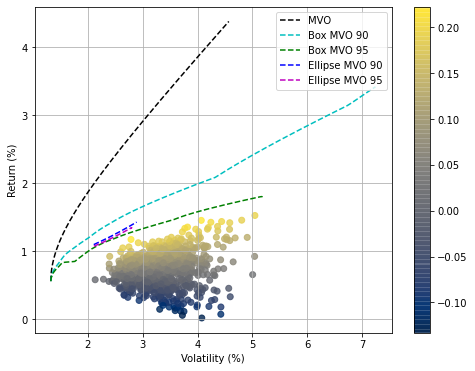

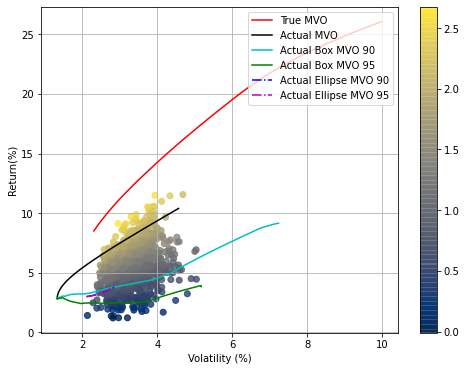

In [ ]:
num_obs = monthly_per.shape[0]
rets2,sds2,retsP2,sdsP2,Sharpe2 = GenerateFrontiers(ret_jan,cov_jan,mu_yr/12,Sigma/12,rf/12,rf_jan,num_obs,same=False)

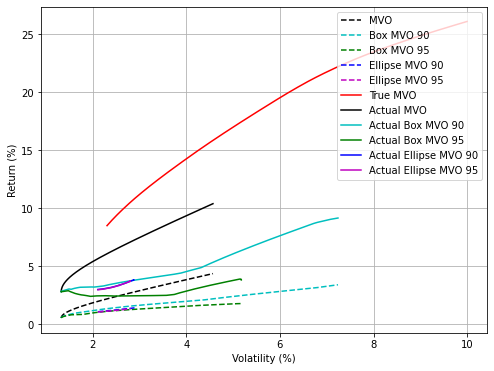

In [ ]:
GenFrontierPlots(rets2,sds2,retsP2,sdsP2,Sharpe2,same=True,save=True,scatter=False)

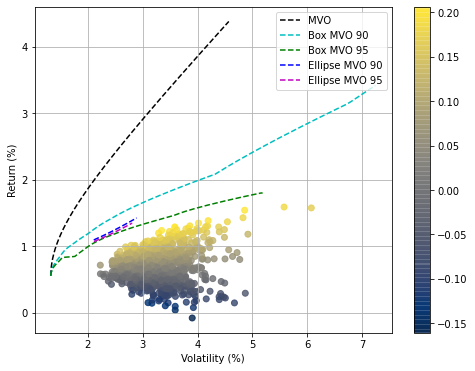

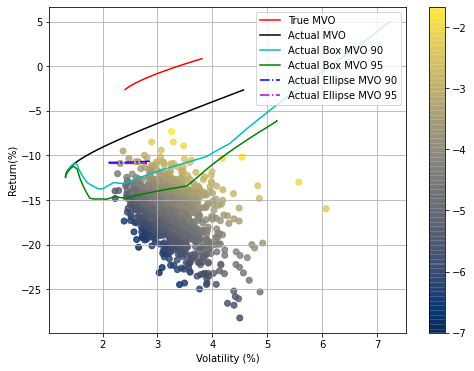

In [ ]:
#Calculate Efficient Frontier for October
#Performance is bad!
ret_oct = monthly_per.loc['2008-10-1'].values.reshape(20,1)
rets0,sds0,retsP0,sdsP0,Sharpe0 = GenerateFrontiers(ret_oct,cov_oct,mu_yr/12,Sigma/12,rf/12,rf_oct,num_obs,same=False)

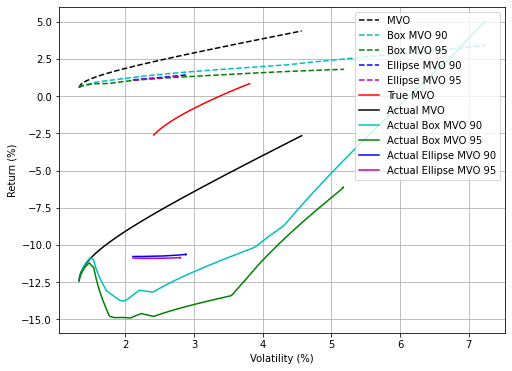

In [ ]:
GenFrontierPlots(rets0,sds0,retsP0,sdsP0,Sharpe0,same=True,save=True,scatter=False)

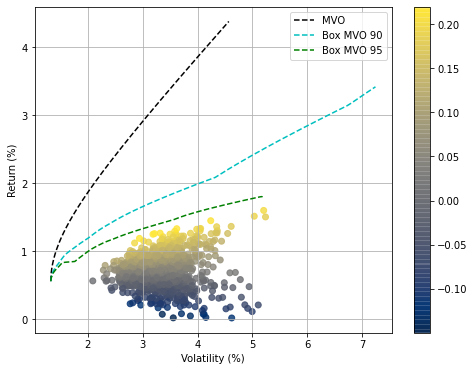

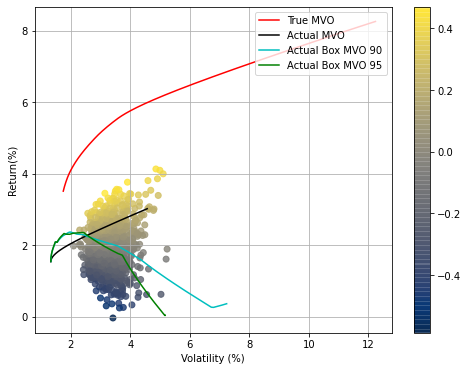

In [ ]:
#Run a final sanity check
#This time for a january with more "regular" returns
jan07 = monthly_per.loc['2007-01-01'].values.reshape(20,1)
rf_07 = (bond1M.loc['2007-1-1','GS1M'] - CPI.loc['2007-1-1','MEDCPIM158SFRBCLE'])/100
rets3,sds3,retsP3,sdsP3,Sharpe3 = GenerateFrontiers(jan07,Sigma/12,mu_yr/12,Sigma/12,rf/12,rf_07,num_obs,same=False)

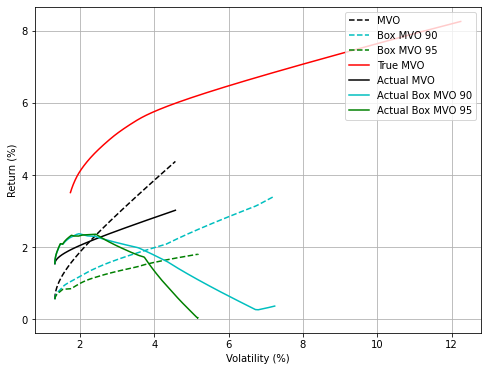

In [ ]:
GenFrontierPlots(rets3,sds3,retsP3,sdsP3,Sharpe3,same=True,save=True,scatter=False)

In [ ]:
hist = []
for n in range(monthly_per.shape[0]):
  hist.append(np.size(np.where(monthly_per.iloc[n]>0)))

plt.hist(hist,bins=np.arange(0.5,20.5,1.0),color='black',)
plt.grid()
plt.xlabel('Number of assets reporting losses')
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.ylabel('Count')
plt.savefig('loss_hist.png')